<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Machine Learning Well-documented, Demonstration Python Workflows 

### k-nearest Neighbours Regression

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

By Michael J. Pyrcz <br />
&copy; Copyright 2024. 

This is a tutorial for / demonstration of **k-nearest Neighbours Regression**. 

**YouTube Lecture**: check out my lectures on:

* [Introduction to Machine Learning](https://youtu.be/zOUM_AnI1DQ?si=wzWdJ35qJ9n8O6Bl)
* [k-nearest Neighbours Regression](https://youtu.be/lzmeChSYvv8?si=nfcvGtkIAQ7rFkjo)

These lectures are all part of my [Machine Learning Course](https://youtube.com/playlist?list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&si=XonjO2wHdXffMpeI) on YouTube with linked well-documented Python workflows and interactive dashboards. My goal is to share accessible, actionable, and repeatable educational content. If you want to know about my motivation, check out [Michael's Story](https://michaelpyrcz.com/my-story). 

#### Motivations for k-nearest Neighbours Regression

There are many good reasons to cover k-nearest neighbours regression. In addition to being a simple, interpretable and flexible predictive machine learning model, it also demonstrates important concepts,
* **non-parametric predictive model** - that learns the form of the relationships from the data, i.e., no prior assumption about the form of the relationship
* **instance-based, lazy learning** - model training is postponed until prediction is required, no precalculation of the model. i.e., prediction requires access to the data
* **hyperparameter tuning** - with a understandable hyperparameters that control model fit
* **very flexible, versatile predictive model** - performs well in many situations

Here are more details about each of these aspects of k-nearest neighbours.

**Predictive Model**

* non-parametric method for regression and classification

* a function $\hat{f}$ of the nearest $k$ training data in predictor feature space such that we predict a response feature $Y$ from a set of predictor features $X_1,\ldots,X_m$. 

* the prediction is of the form $\hat{Y} = \hat{f}(X_1,\ldots,X_m)$ 

* for classification the majority response category among the $k$ nearest training data is selected as the prediction

* for regression the average (or other weighted average, like inverse distance weighted) of the response features among the $k$ nearest training data is assigned as the prediction 

**Supervised Learning**

* the response feature label, $Y$, is available over the training and testing data

**Instance-based Learning / Lazy Learning**

* the prediction function is approximated locally and calculation is defered until a prediction is needed

* there is no compact 'model' that can be shared without the data. The model is the training data and the hyperparameters!
    
**Hyperparameters**

* **k number of nearest data** to utilize for prediction

* **data weighting**, for example uniform weighting (use local training data average), inverse distance weighting

Note, for the case of inverse distance weighting, the method is analogous to inverse distance weighted interpolation with a maximum number of local data constraint commonly applied for spatial interpolation.  Inverse distance is available in GeostatsPy for spatial mapping.

* **distance metric** - more below

**Distance Metric**

* training data within the predictor feature space are ranked by distance (closest to farthest)

* a variety of distance metrics may be applied, including:

1. euclidian distance 

\begin{equation}    
d_i = \sqrt{\sum_{\alpha = 1}^{m} \left(x_{\alpha,i} - x_{\alpha,0}\right)^2} 
\end{equation}

2. overlap metric / Hamming distance used for discrete variables
    
3. correlation coefficients used for comparing sets and images 

#### Load the required libraries

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
%matplotlib inline                                         
supress_warnings = True
import os                                                     # to set current working directory 
import math                                                   # square root operator
import numpy as np                                            # arrays and matrix math
import scipy.stats as st                                      # statistical methods
import pandas as pd                                           # DataFrames
import pandas.plotting as pd_plot
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import seaborn as sns                                         # for matrix scatter plots
from sklearn import metrics                                   # measures to check our models
from sklearn.preprocessing import StandardScaler              # standardize the features
from sklearn.neighbors import KNeighborsRegressor             # for nearest k neighbours
from sklearn import metrics                                   # measures to check our models
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV,KFold) # model tuning
from sklearn.pipeline import (Pipeline,make_pipeline)         # machine learning modeling pipeline
from IPython.display import display, HTML                     # custom displays
cmap = plt.cm.inferno                                         # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                                # grid behind plotting elements
if supress_warnings == True:  
    import warnings                                           # supress any warnings for this demonstration
    warnings.filterwarnings('ignore') 
seed = 13                                                     # random number seed for workflow repeatability

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices, visualization of a decision tree regression model, and the addition specified percentiles and major and minor gridlines to our plots. 

In [2]:
def comma_format(x, pos):
    return f'{int(x):,}'

def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal); m = len(pred) + 1
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,m-1.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,m-1.5]); add_grid();
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,axes_commas = True): # plots the data points and the decision tree prediction 
    n_classes = 10
    cmap_temp = plt.cm.inferno
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap_temp,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=30, c=response, marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors="black",zorder=10)
    plt.scatter(xfeature,yfeature,s=60, c='white', marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors=None,zorder=8)
    plt.title(title); plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical'); cbar.set_label(response.name, rotation=270, labelpad=20)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    if axes_commas == True:
        plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    return Z
    
def visualize_tuned_model(k_tuned,k_mat,score_mat):
    plt.scatter(k_mat,score_mat,s=10.0, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, 
                linewidths=0.5, edgecolors="black")
    plt.plot([k_tuned,k_tuned],[0,10000000],color='black',linestyle=(6, (2,3)),label='tuned',zorder=1)
    plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours')
    plt.ylabel('Mean Square Error')
    plt.xlim(k_min,k_max); plt.ylim(0,np.max(score_mat))
    
def check_model(model,xtrain,ytrain,xtest,ytest,ymin,ymax,rtrain,rtest,title): # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xtrain,ytrain])
    predict_test = model.predict(np.c_[xtest,ytest])
    plt.scatter(rtrain,predict_train,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Train')
    plt.scatter(rtest,predict_test,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Test')
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(ymin,ymax); plt.ylim(ymin,ymax)
    plt.arrow(ymin,ymin,ymax,ymax,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE_train = metrics.mean_squared_error(rtrain,predict_train)
    Var_Explained_train = metrics.explained_variance_score(rtrain,predict_train)
    cor_train = math.sqrt(metrics.r2_score(rtrain,predict_train))
    MSE_test = metrics.mean_squared_error(rtest,predict_test)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.annotate('Train MSE: ' + str(f'{(np.round(MSE_train,2)):,}'),[0.05*(ymax-ymin)+ymin,0.95*(ymax-ymin)+ymin]) 
    plt.annotate('Test MSE:  ' + str(f'{(np.round(MSE_test,2)):,}'),[0.05*(ymax-ymin)+ymin,0.90*(ymax-ymin)+ymin])
    add_grid(); plt.legend(loc='lower right')
    # print('Mean Squared Error on Training = ', round(MSE_test,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks 

def display_sidebyside(*args):                                # display DataFrames side-by-side (ChatGPT 4.0 generated Spet, 2024)
    html_str = ''
    for df in args:
        html_str += df.head().to_html()  # Using .head() for the first few rows
    display(HTML(f'<div style="display: flex;">{html_str}</div>'))

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).


In [3]:
#os.chdir("c:/PGE383")                                        # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE").  

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

Let's load the provided multivariate, spatial dataset 'unconv_MV.csv'. This dataset has variables from 1,000 unconventional wells including:

* well average porosity
* log transform of permeability (to linearize the relationships with other variables)
* accoustic impedance (kg/m^3 x m/s x 10^6)
* brittness ratio (%)
* total organic carbon (%)
* vitrinite reflectance (%)
* initial production 90 day average (MCFPD).  

Note, the dataset is synthetic.

We load it with the pandas 'read_csv' function into a DataFrame we called 'my_data' and then preview it to make sure it loaded correctly.

#### Optional: Add Random Noise to the Response Feature

We can do this to observe the impact of data noise on overfit and hyperparameter tuning.

* This is for experiential learning, of course we wouldn't add random noise to our data
* We set the random number seed for reproducibility

In [4]:
df_load = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv') # load data from Dr. Pyrcz's GitHub respository  
df_load = df_load.iloc[:,1:8]                                           # copy all rows and columns 1 through 8, note 0 column is removed

response = 'Prod'                                             # specify the response feature
add_noise = True                                              # set True to add noise to response feature to demonstrate overfit
noise_stdev = 500                                             # amount of noise to add to response feature to demonstrate overfit

np.random.seed(seed = seed)                                   # set the random number seed
if add_noise == True:
    df_load[response] = df_load[response] + np.random.normal(loc=0.0,scale=noise_stdev,size = len(df_load))

X = df_load.copy(deep = False)
X = X.drop([response],axis='columns')                         # make predictor and response DataFrames
y = df_load.loc[:,response]

features = X.columns.values.tolist() + [y.name]               # store the names of the features
pred = X.columns.values.tolist()
resp = [y.name]

Xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; Xmax = [24.0,10.0,5.0,85.0,2.2,2.9] # set the minumum and maximum values for plotting
ymin = 1000.0; ymax = 9000.0

predlabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', # set the names for plotting
             'Total Organic Carbon (%)','Vitrinite Reflectance (%)']
resplabel = 'Normalized Initial Production (MCFPD)'

predtitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', # set the units for plotting
             'Total Organic Carbon','Vitrinite Reflectance']
resptitle = 'Initial Production'

featurelabel = predlabel + [resplabel]                        # make feature labels and titles for concise code
featuretitle = predtitle + [resptitle]

m = len(pred) + 1
mpred = len(pred)

df = pd.concat([X,y],axis=1)                                  # make one DataFrame with both X and y (remove all other features)

#### Visualize the DataFrame

Visualizing the DataFrame is useful first check of the data.

* many things can go wrong, e.g., we loaded the wrong data, all the features did not load, etc.

We can preview by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). 

* add parameter 'n=13' to see the first 13 rows of the dataset.  

In [5]:
df.head(n=13)

,Por,Perm,AI,Brittle,TOC,VR,Prod
0,12.08,2.92,2.80,81.40,1.16,2.31,1339.165488
1,12.38,3.53,3.22,46.17,0.89,1.88,3383.979252
2,14.02,2.59,4.01,72.80,0.89,2.72,2509.686720
3,17.67,6.75,2.63,39.81,1.08,1.88,5514.421023
4,17.52,4.57,3.18,10.94,1.51,1.90,3532.020478
5,14.53,4.81,2.69,53.60,0.94,1.67,4283.543382
6,13.49,3.60,2.93,63.71,0.80,1.85,3627.906723
7,11.58,3.03,3.25,53.00,0.69,1.93,3101.539533
8,12.52,2.72,2.43,65.77,0.95,1.98,3213.391047
9,13.25,3.94,3.71,66.20,1.14,2.65,2200.204701


#### Summary Statistics for Tabular Data

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum in a nice data table. 

* we have some negative TOC values! Let's check the distribution.

In [6]:
df.describe().transpose()                                     # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.40250,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.28750,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.34500,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.26250,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.35000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.14250,2.870000
Prod,200.0,3842.630027,1594.301295,803.640483,2551.414599,3626.229052,4739.73408,9021.792491


* There are just a couple slighly negative values, let's just truncate them at zero. We   can use this command below to set all TOC values in the DataFrame that are less than 0.0 as 0.0, otherwise we keep the original TOC value.

In [7]:
num = df._get_numeric_data()                                  # get the numerical values
num[num < 0] = 0                                              # truncate negative values to 0.0
df.describe().transpose()                                     # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.40250,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.28750,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.34500,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.26250,84.330000
TOC,200.0,0.991950,0.478264,0.000000,0.617500,1.030000,1.35000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.14250,2.870000
Prod,200.0,3842.630027,1594.301295,803.640483,2551.414599,3626.229052,4739.73408,9021.792491


It is good that we checked the summary statistics.

* there are no obvious issues
* check out the range of values for each feature to set up and adjust plotting limits. See above.

#### Calculate the Correlation Matrix and Correlation with Response Ranking 

Let's perform with correlation analysis. We can calculate and view the correlation matrix and correlation to the response features with these previously declared functions.
* correlation analysis is based on the assumption of linear relationships, but it is a good start

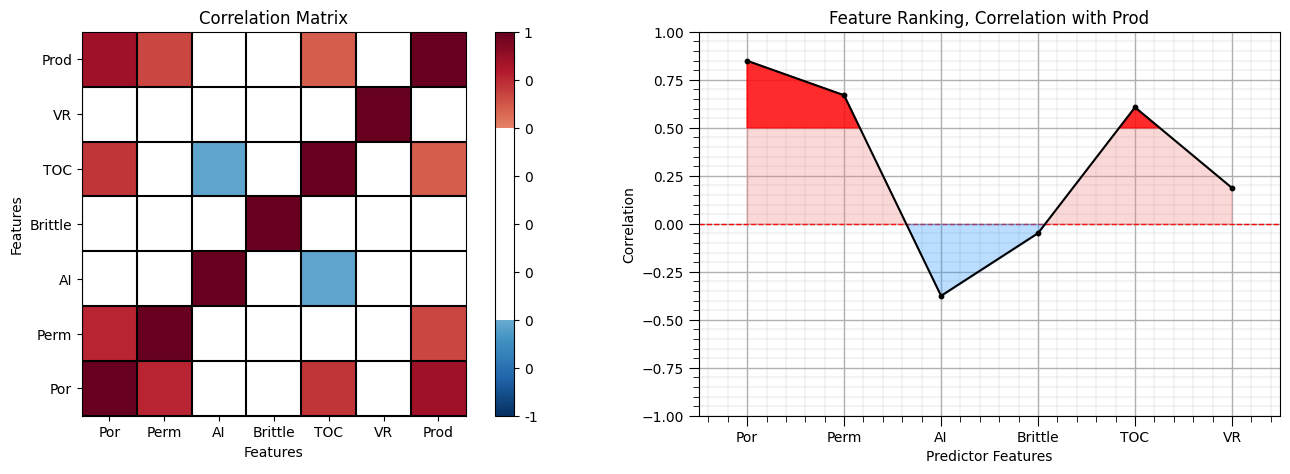

In [8]:
corr_matrix = df.corr()
correlation = corr_matrix.iloc[:,-1].values[:-1]

plt.subplot(121)
plot_corr(corr_matrix,'Correlation Matrix',1.0,0.5)           # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp[0],'Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  

* Let's look at the matrix scatter plot to see the pairwise relationship between the features.

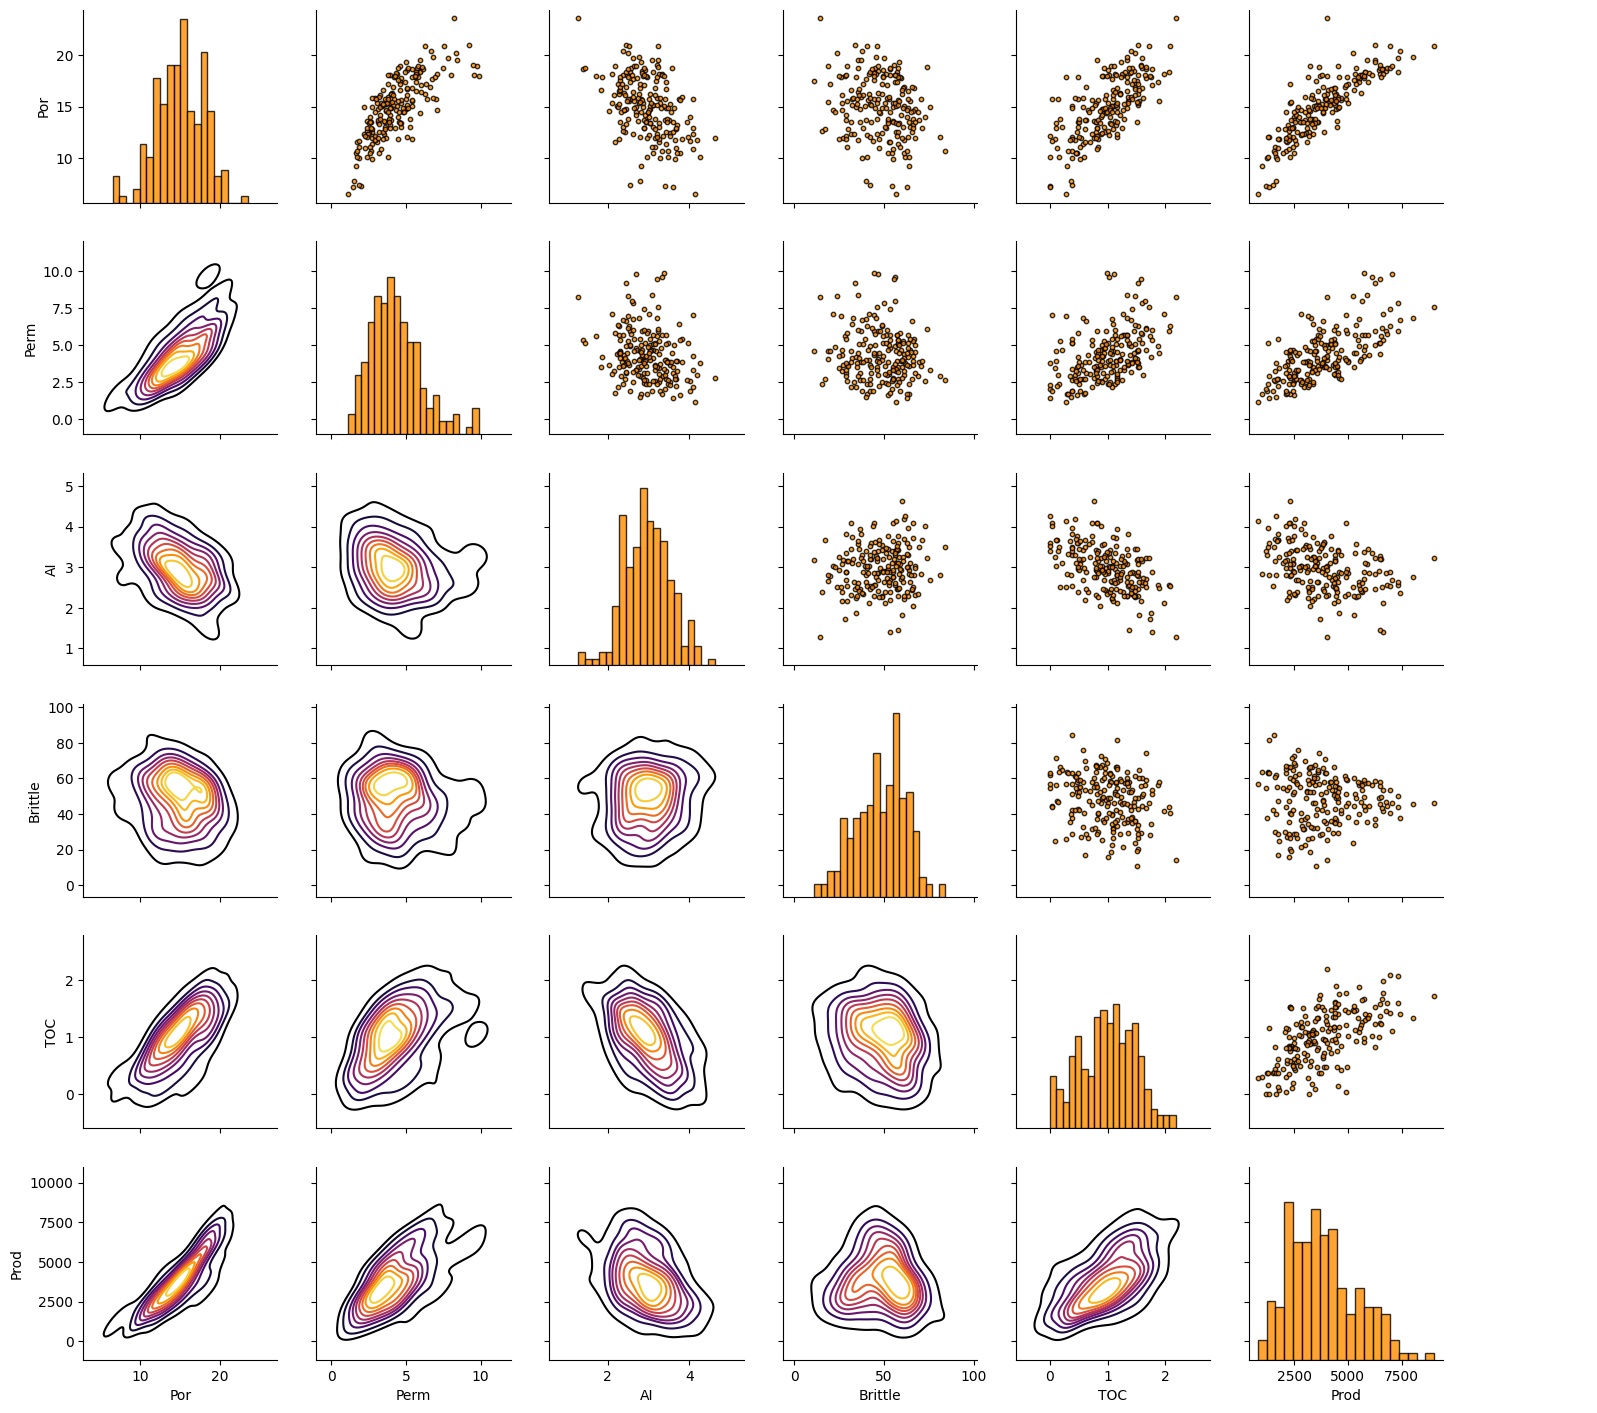

In [9]:
pairgrid = sns.PairGrid(df,vars=['Por','Perm','AI','Brittle','TOC','Prod']) # matrix scatter plots
pairgrid = pairgrid.map_upper(plt.scatter, color = 'darkorange', edgecolor = 'black', alpha = 0.8, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'darkorange',alpha = 0.8, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2); plt.show()

#### Working with Only Two Predictor Features

Let's simplify the problem to 2 predictor features, Porosity and Brittleness to predict Production rate.  By working with only 2 features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown completely on a single plot).

#### Standardizing Predictor Features

The k-nearest neighbour method uses a nearest training sample search in feature space (like k-means clustering). To remove the impact feature range from the approach we standardize the features.

* we will standardize our predictor features to have a mean of zero and a variance of one.
* we use the scikit-learn preprocessing to simplify this step and provid a reverse transform.

In [10]:
if1 = 0; if2 = 3                                              # selected predictor features

transform = StandardScaler();                                 # instantiate feature standardization method

sel_pred = [pred[if1],pred[if2]]
sel_features = pred + [resp]

spredlabel = ['Standardized ' + element for element in predlabel] # standardized predictors list

sel_spredlabel = [spredlabel[if1]] + [spredlabel[if2]] 

sel_spred = ['s' + element for element in sel_pred]           # standardized predictors list

df[sel_spred[0]] = transform.fit_transform(df.loc[:,sel_pred].values)[:,0] # standardize the data features to mean = 0, var = 1.0
df[sel_spred[1]] = transform.fit_transform(df.loc[:,sel_pred].values)[:,1] # standardize the data features to mean = 0, var = 1.0

print('Selected Predictor Features: ' + str(sel_pred))
print('Standardized Selected Predictor Features: ' + str(sel_spred))
print('Response Feature: ' + str([resp]))
df.head()

Selected Predictor Features: ['Por', 'Brittle']
Standardized Selected Predictor Features: ['sPor', 'sBrittle']
Response Feature: [['Prod']]


,Por,Perm,AI,Brittle,TOC,VR,Prod,sPor,sBrittle
0,12.08,2.92,2.80,81.40,1.16,2.31,1339.165488,-0.982256,2.358297
1,12.38,3.53,3.22,46.17,0.89,1.88,3383.979252,-0.881032,-0.141332
2,14.02,2.59,4.01,72.80,0.89,2.72,2509.686720,-0.327677,1.748113
3,17.67,6.75,2.63,39.81,1.08,1.88,5514.421023,0.903875,-0.592585
4,17.52,4.57,3.18,10.94,1.51,1.90,3532.020478,0.853263,-2.640962


Let's demonstrate the reverse transform from standarized features back to the original features.

* we won't need this in our workflow since the we only need to forward transform the predictor features to train the model and make predictions

In [11]:
print('Backtransformed: \n        Por    Brittle')
transform.inverse_transform(df.loc[:,sel_spred])[:5,:]        # check the reverse standardization

Backtransformed: 
        Por    Brittle


array([[12.08, 81.4 ],
       [12.38, 46.17],
       [14.02, 72.8 ],
       [17.67, 39.81],
       [17.52, 10.94]])

We can compare the output above with the original porosity and brittleness. The reverse transform works! 

* We will use this method to return to original feature units when needed.
* In general, the back transformation is not needed for predictor features, well only forward transform the predictor features to make predictions of the response feature.
* In this example, we don't need to transform the response feature while building our model. The response feature distribution is well-behaved and there is not theory in k-nearest neighbours that expects a specific range or distribution share for the response feature.

#### Feature Ranges

Let's set some ranges for plotting. Note for the standardized predictor features we will use -3.5 to 3.5 as the limits.

In [12]:
Xmin = [5.0, 0.0]; Xmax = [25.0,100.0]                        # selected predictor features min and max

#### Train and Test Split

For convenience and simplicity we use scikit-learn's random train and test split.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,sel_spred],df.loc[:,resp],test_size=0.25,random_state=73073)
df_train = pd.concat([X_train,y_train],axis=1)                # make one train DataFrame with both X and y (remove all other features)
df_test = pd.concat([X_test,y_test],axis=1)                   # make one testin DataFrame with both X and y (remove all other features)

Let's first check the univariate statistics of Porosity, Brittleness and Producton.

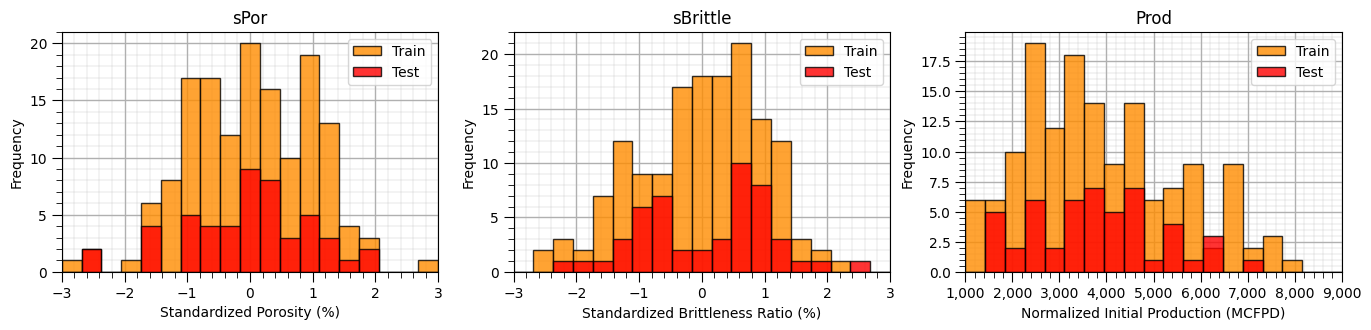

In [14]:
nbins = 20                                                    # number of histogram bins

plt.subplot(231)
plt.hist(X_train[sel_spred[0]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test[sel_spred[0]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(sel_spred[0]); plt.xlim(-3,3); plt.xlabel(sel_spredlabel[0]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(232)
plt.hist(X_train[sel_spred[1]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test[sel_spred[1]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(sel_spred[1]); plt.xlim(-3,3); plt.xlabel(sel_spredlabel[1]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(233)
plt.hist(y_train[resp],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Train')
plt.hist(y_test[resp],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Test')
plt.legend(loc='upper right'); plt.title(resp[0]); plt.xlim(ymin,ymax) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
plt.xlabel(resplabel); plt.ylabel('Frequency'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

The distributions are well behaved, 

* we cannot observe obvious gaps nor truncations.
* check coverage of the train and test data

Let's look at a scatter plot of Porosity vs. Brittleness with points colored by Production.

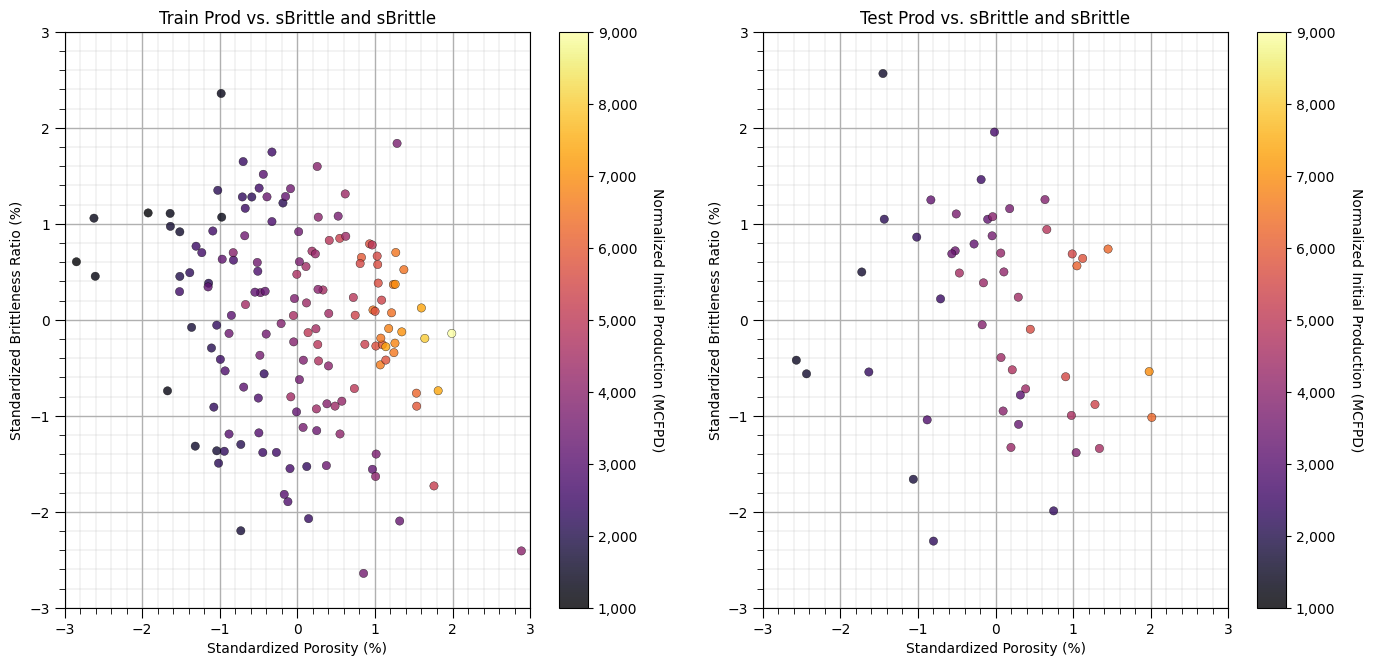

In [15]:
plt.subplot(121)                                              # train data plot
im = plt.scatter(X_train[sel_spred[0]],X_train[sel_spred[1]],s=None, c=y_train[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Train ' + resp[0] + ' vs. ' + sel_spred[1] + ' and ' + sel_spred[1]); plt.xlabel(sel_spredlabel[0]); plt.ylabel(sel_spredlabel[1])
plt.xlim(-3,3); plt.ylim(-3,3)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplot(122)                                               # test data plot
im = plt.scatter(X_test[sel_spred[0]],X_test[sel_spred[1]],s=None, c=y_test[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Test ' + resp[0] + ' vs. ' + sel_spred[1] + ' and ' + sel_spred[1]); plt.xlabel(sel_spredlabel[0]); plt.ylabel(sel_spredlabel[1])
plt.xlim(-3,3); plt.ylim(-3,3)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

This problem looks nonlinear and could not be modeled with simple linear regression.

* It appears there is a sweet spot for Brittleness and increasing Porosity is always beneficial for Production.

#### Instantiate, Fit and Predict with k-nearest Neighbour

Let's instantiate, fit and predict with a k-nearest neighbour model.

* instantiate it with the hyperparameters, k-nearest neighbours 
* train with the training data, we use the standard fit function from scikit-learn 

In [16]:
n_neighbours = 10; p = 2; weights = 'uniform'                 # model hyperparameters
neigh = KNeighborsRegressor(weights = weights, n_neighbors=n_neighbours, p = p) # instantiate the prediction model

We have set the hyperparameters:
* weights = averaging weights for the prediction given the nearest neighbours. 'uniform' is arithmetic average, while 'distance' is inverse distance weighting.
* n_neighbours = maximum number of neighbours. Note, we constrain our prediction by limiting it to 5 nearest neighbours.
* p = distance metric power or Minkowski metric (1 = Manhattan distance, 2 for Euclidian distance) for finding the nearest neighbours.

Now we are ready to fit our model for prediction of Production given Porosity and Brittleness.  

* We will use our two functions defined above to visualize the k-nearest neighbour prediction over the feature space and the cross plot of actual and estimated production for the training data along with three model metrics from the sklearn.metric module.

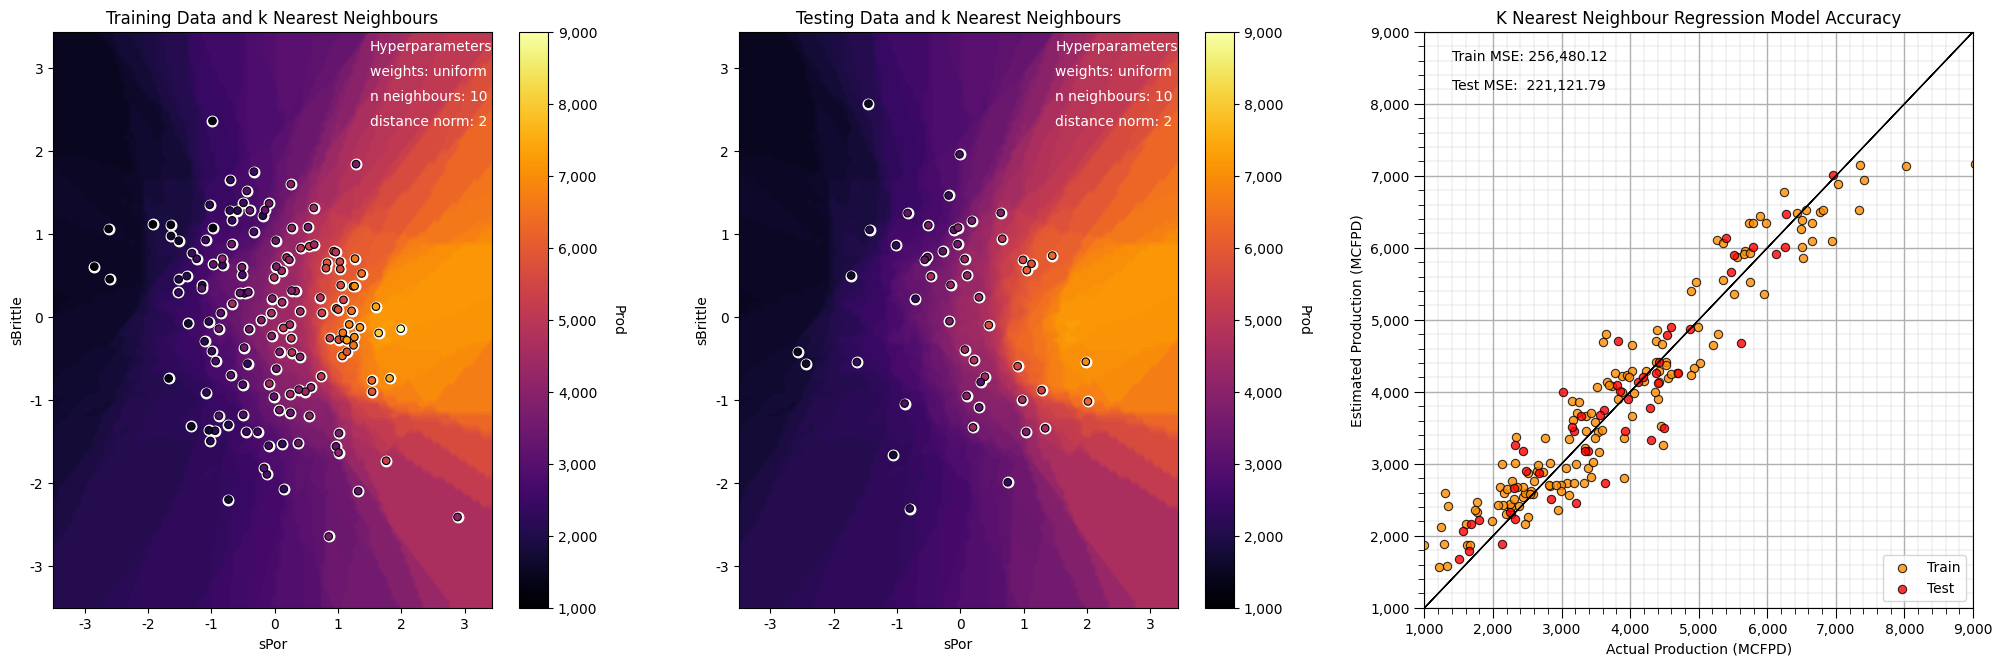

In [17]:
neigh_fit = neigh.fit(X_train,y_train)                        # train the model with the training data

plt.subplot(131)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train[sel_spred[0]],-3.5,3.5,X_train[sel_spred[1]],-3.5,3.5,y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(132)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test[sel_spred[0]],-3.5,3.5,X_test[sel_spred[1]],-3.5,3.5,y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(133)                                              # model accuracy check
check_model(neigh_fit,X_train[sel_spred[0]],X_train[sel_spred[1]],X_test[sel_spred[0]],X_test[sel_spred[1]],ymin,ymax,
            y_train[resp[0]],y_test[resp[0]],'K Nearest Neighbour Regression Model Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.25, hspace=0.2); plt.show()

The model looks good:

* the nonparametric approach is quite flexible to fit the nonlinear response patterns in the predictor feature space
* we can see some search artifacts due to limited k nearest data and the use of uniform weighting
* we have dense data for this low dimensional problem (only 2 predictor features)
* the testing and training data are consistent and close to each other in the predictor feature space

Let's try to overfit the model by using a very large k hyperparameter.

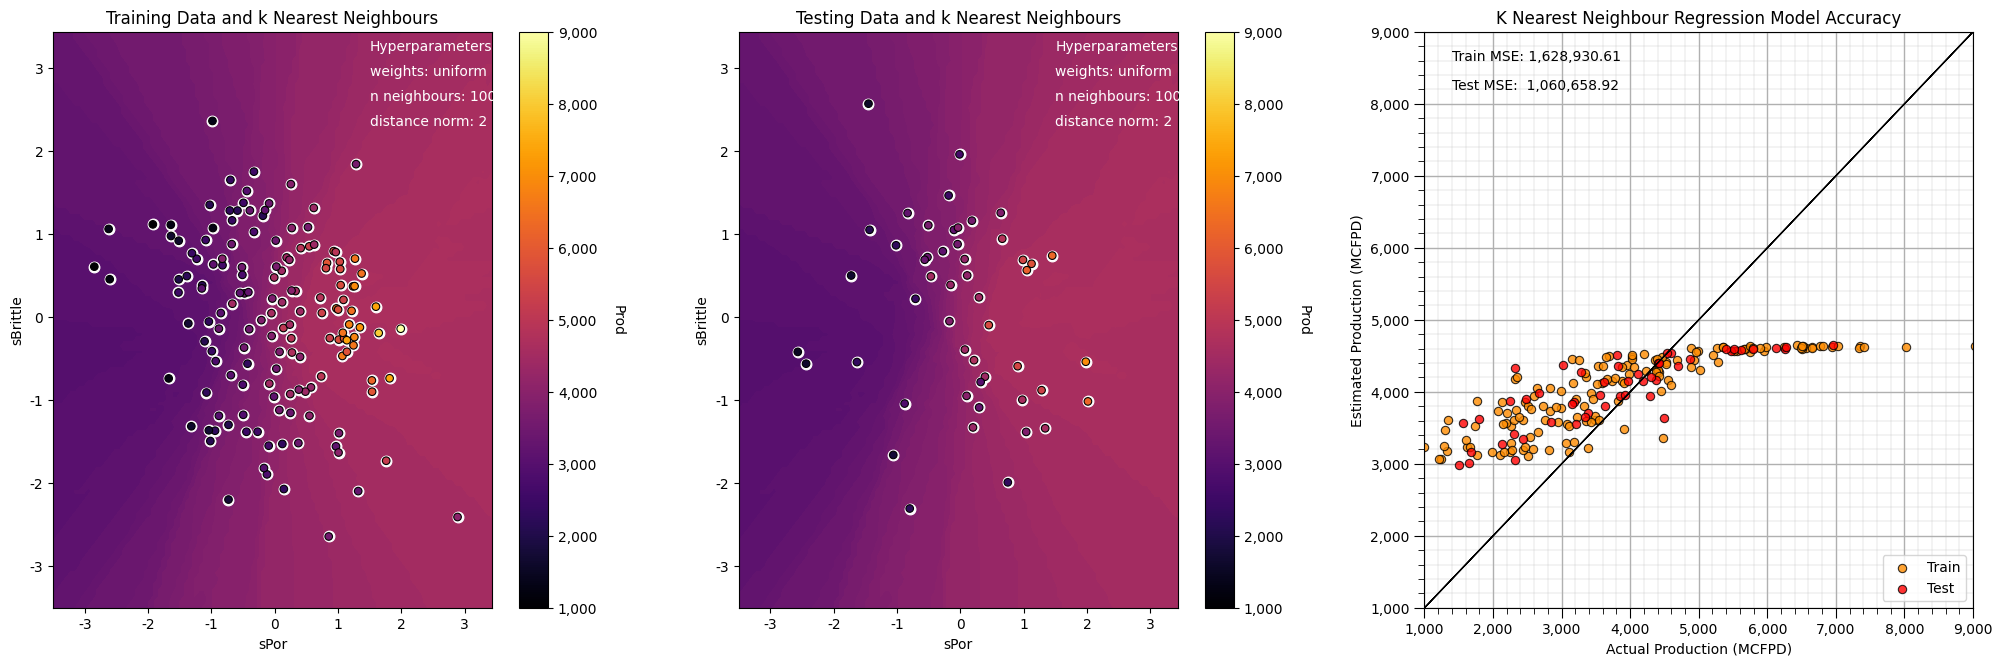

In [18]:
n_neighbours = 100; p = 2; weights = 'uniform'                # model hyperparameters
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) # instantiate the prediction model

neigh_fit = neigh.fit(X_train,y_train)                        # train the model with the training data

plt.subplot(131)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train[sel_spred[0]],-3.5,3.5,X_train[sel_spred[1]],-3.5,3.5,y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(132)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test[sel_spred[0]],-3.5,3.5,X_test[sel_spred[1]],-3.5,3.5,y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(133)                                              # model accuracy check
check_model(neigh_fit,X_train[sel_spred[0]],X_train[sel_spred[1]],X_test[sel_spred[0]],X_test[sel_spred[1]],ymin,ymax,
            y_train[resp[0]],y_test[resp[0]],'K Nearest Neighbour Regression Model Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.25, hspace=0.2); plt.show()

Note that this smoothed out the response, and the predictions are approaching the global mean.

* we have an underfit model.

Next let's use a smaller k hyperparameter for our k-nearest neighbours prediction model.  

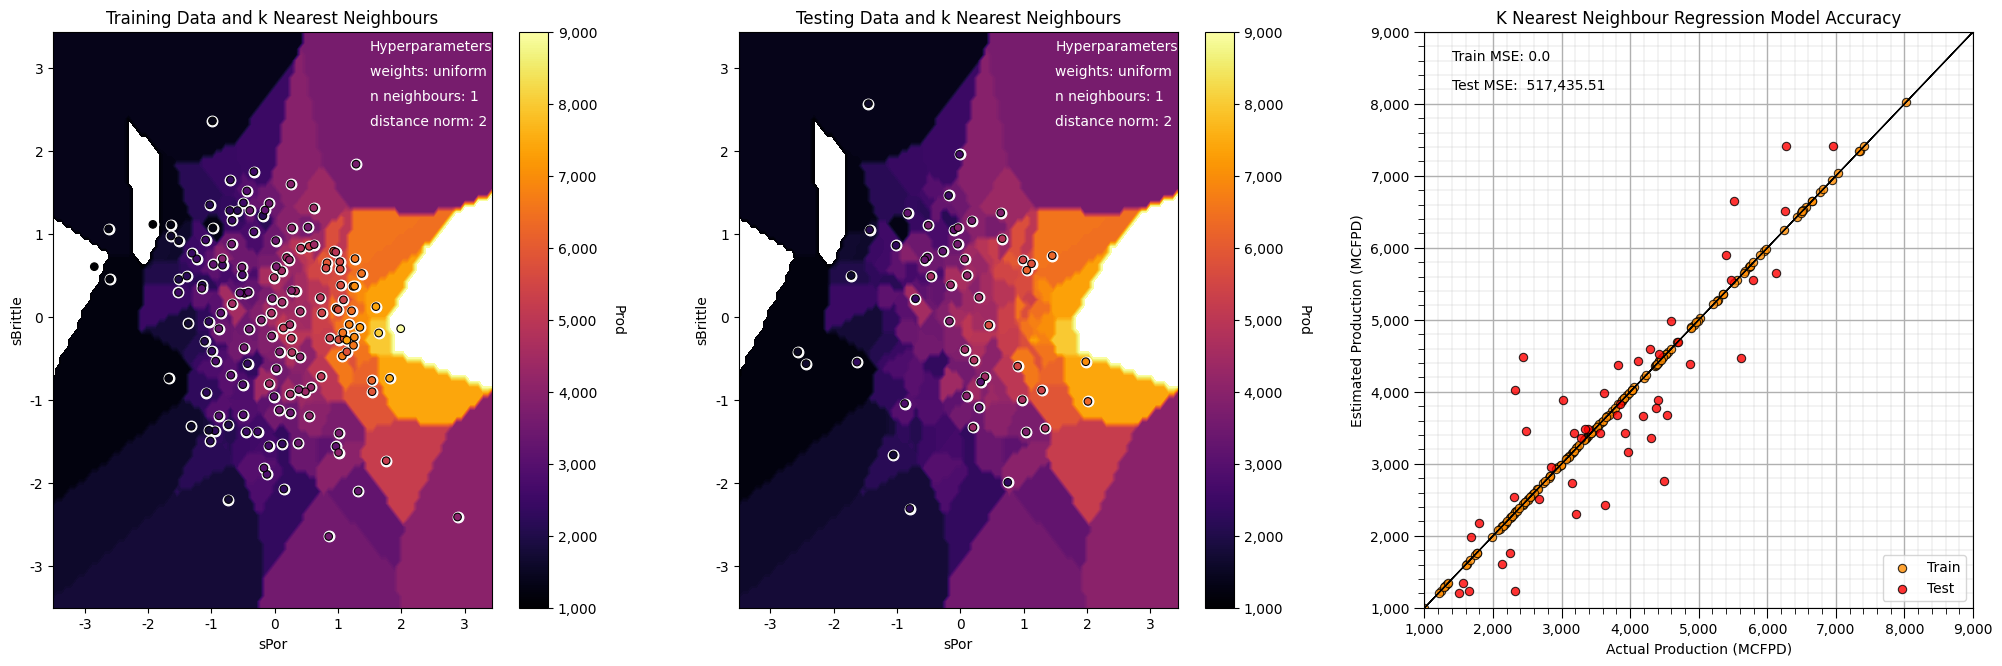

In [19]:
n_neighbours = 1; p = 2; weights = 'uniform'                  # model hyperparameters
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) # instantiate the prediction model

neigh_fit = neigh.fit(X_train,y_train)                        # train the model with the training data

plt.subplot(131)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train[sel_spred[0]],-3.5,3.5,X_train[sel_spred[1]],-3.5,3.5,y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(132)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test[sel_spred[0]],-3.5,3.5,X_test[sel_spred[1]],-3.5,3.5,y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(133)                                              # model accuracy check
check_model(neigh_fit,X_train[sel_spred[0]],X_train[sel_spred[1]],X_test[sel_spred[0]],X_test[sel_spred[1]],ymin,ymax,
            y_train[resp[0]],y_test[resp[0]],'K Nearest Neighbour Regression Model Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.25, hspace=0.2); plt.show()

Now we have an extreme overfit model. 

* The training MSE is 0.0 and the testing error is quite high.
* Note, some of our predictions in our overfit model are outside the plotting min and max response feature values.

 Let's try to use a L1, Manhattan distance to find the k nearest neighbours.

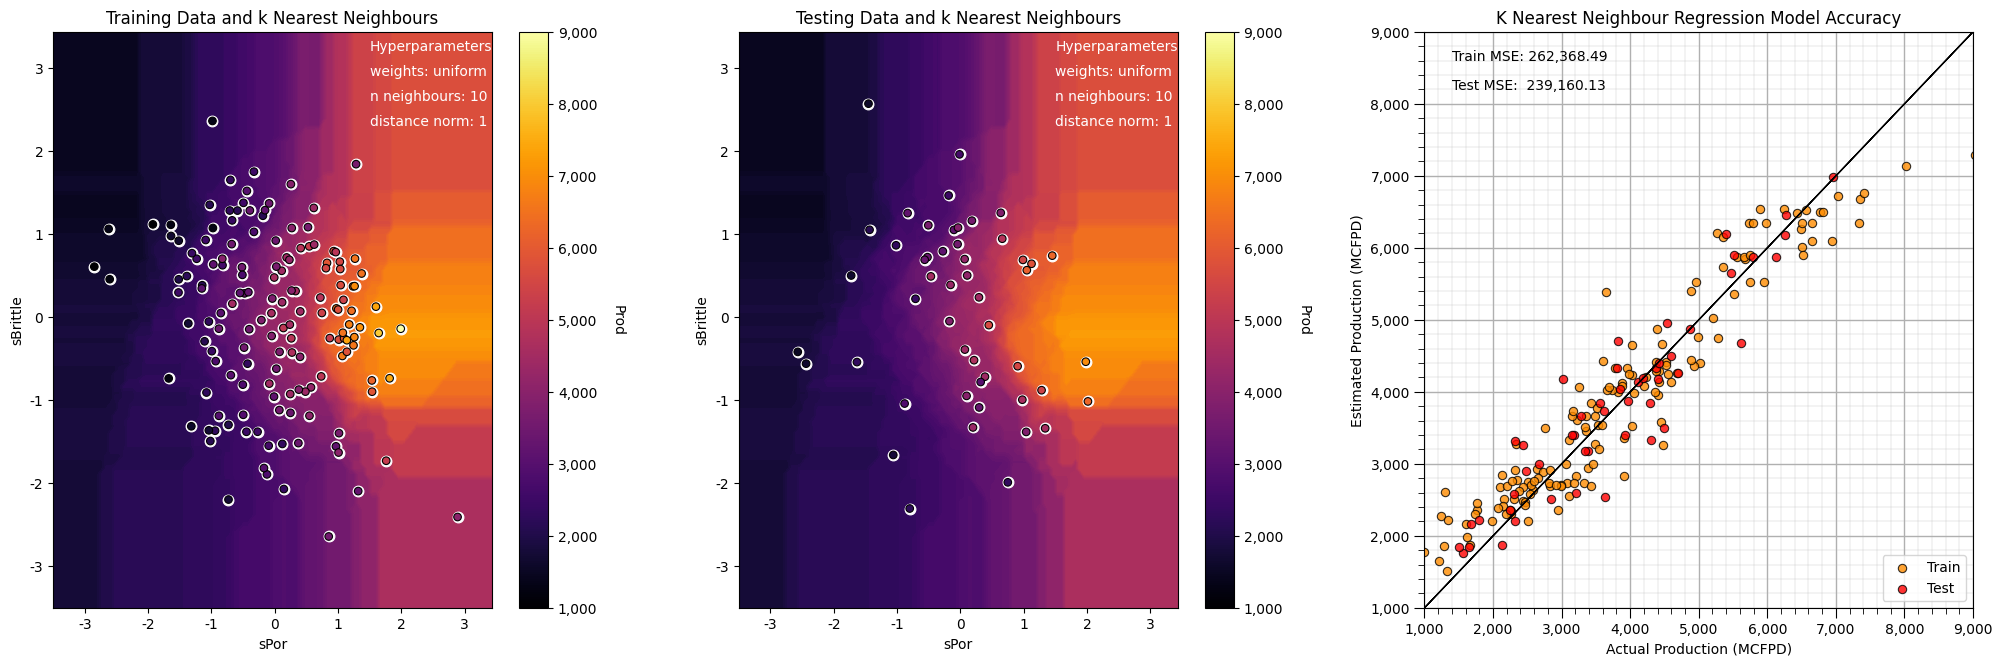

In [20]:
n_neighbours = 10; p = 1; weights = 'uniform'                 # model hyperparameters
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) # instantiate the prediction model

neigh_fit = neigh.fit(X_train,y_train)                        # train the model with the training data

plt.subplot(131)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train[sel_spred[0]],-3.5,3.5,X_train[sel_spred[1]],-3.5,3.5,y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(132)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test[sel_spred[0]],-3.5,3.5,X_test[sel_spred[1]],-3.5,3.5,y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(133)                                              # model accuracy check
check_model(neigh_fit,X_train[sel_spred[0]],X_train[sel_spred[1]],X_test[sel_spred[0]],X_test[sel_spred[1]],ymin,ymax,
            y_train[resp[0]],y_test[resp[0]],'K Nearest Neighbour Regression Model Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.25, hspace=0.2); plt.show()

Compare this prediction model to our first model, all we changes is the distance search for the k nearest samples to Manhattan from Euclidean distance.

* the search artifacts are now alligned on the features (the rays are oriented in the x and y directions)

#### Hyperparameter Tuning for k-Nearest Neighbours 
 
Let's check this out as we tune the hyper parameters.

So what does the $k$ do?

* small $k$ hyperparameter results in a local specfic prediction model over the predictor feature space

* large $k$ hyperparameter results in a more smooth, globally fit prediction model over the predictor features space

This is analogous to the low to high complexity we have obseved with other models (like decision trees). 

* small $k$ is complex 

* large $k$ is simple

We need to tune the complexity to optimize model performance.

#### Tuning the Hyperparameters

Let's loop over multiple $k$ nearest neighbours for average and inverse distance estimates to access the best hyperparameters with respect to accuracy in testing.

In [21]:
k = 1                                                         # set initial, lowest k hyperparameter
dist_error = []; unif_error = []; k_mat = []                  # make lists to store the results
while k <= 150:                                               # loop over the k hyperparameter
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 2) # instantiate the model
    neigh_dist_fit = neigh_dist.fit(X_train,y_train)          # train the model with the training data
    y_pred = neigh_dist_fit.predict(X_test)                   # predict over the testing cases
    MSE = metrics.mean_squared_error(y_test,y_pred)           # calculate the MSE testing
    dist_error.append(MSE)                                    # add to the list of MSE
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 2)
    neigh_unif_fit = neigh_unif.fit(X_train,y_train)          # train the model with the training data
    y_pred = neigh_unif_fit.predict(X_test)                   # predict over the testing cases
    MSE = metrics.mean_squared_error(y_test,y_pred)           # calculate the MSE testing
    unif_error.append(MSE)                                    # add to the list of MSE
    
    k_mat.append(k)                                           # append k to an array for plotting
    k = k + 1

Now let's plot the result.

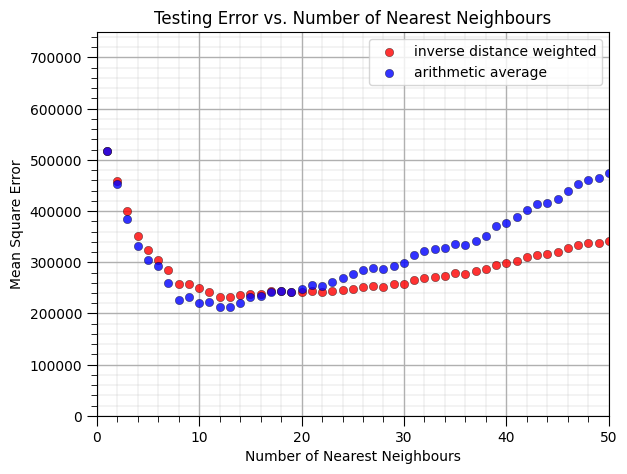

In [22]:
plt.subplot(111)
plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Error vs. Number of Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.legend(); add_grid()
plt.xlim(0,50); plt.ylim([0,750000])
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8,wspace=0.15,hspace=0.2); plt.show()

What can we observe from this result?

* at $k = 12$ nearest neighbours we minimize the mean square error in testing.

* we have better performance with the inverse distance weighted than the arithmetic average (uniform weighting of k nearest training data in predictor feature space)

There is an optimum degree of specifivity / complexity to our model.  

* 1 nearest neighbour is a very locally specific model (overfit)

* many nearest neighbours includes too much information and is too general (underfit)

We are observing the accuracy vs. complexity trade-off for the $k$ nearest neighbour model.

#### k-fold Cross Validation

It is useful to evaluate the performance of our model by observing the accuracy vs. complexity trade-off.   

Yet, what we really want to do is rigorously test our model performance.  We should perform a more rigorous cross validation that does a better job evaluating over different sets of training and testing data. scikit learn has a built in cross validation method called cross_val_score that we can use to:

1. Apply k-fold approach with iterative separation of training and testing data
2. Automate the model construction, looping over folds and averaging the metric of interest

Let's try it out on our k nearest neighbour prediction with variable number of $k$ nearest neighbours.  Note the cross validation is set to use 4 processors, but still will likely take a couple of minutes to run.

In [23]:
score = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat = []
for k in range(1,150):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores = cross_val_score(estimator=neigh_dist, X= np.c_[df['sPor'],df['sBrittle']],y=df['Prod'], cv=4, n_jobs=4,
                             scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    k_mat.append(k)

The output is an array of average scores (MSE) over the k-folds for each level of complexity (number of $k$ nearest neighbours), along with an array with the $k$s.

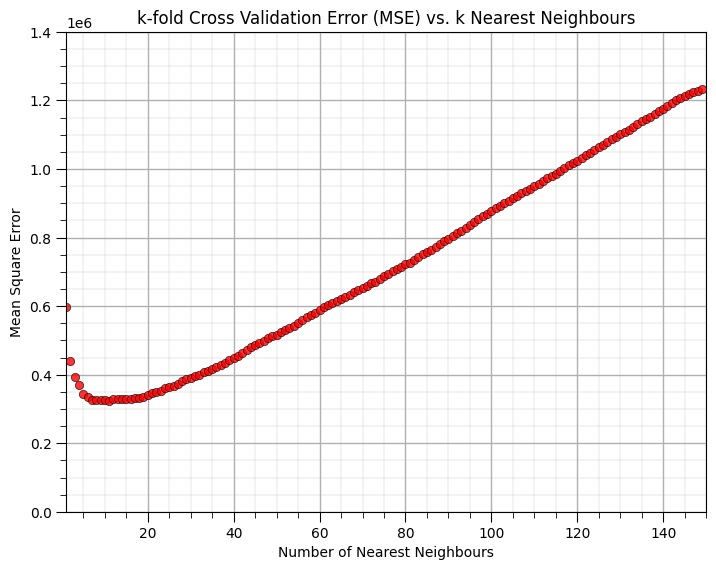

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(k_mat,score,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, edgecolors="black")
plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.xlim(1,150); plt.ylim([0,1400000]); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8,wspace=0.15,hspace=0.2); plt.show()

With the hyperparameter of 10 nearest neighbours we get the greatest accuracy in k-fold cross validation model testing.

#### Predictor Feature Standardization

We have standardized the predictor feature to remove the influence of their ranges.

* What would happen if we worked with the original predictor features?  

Let's try it out.

* we first apply train and test split with the original features, without standardization

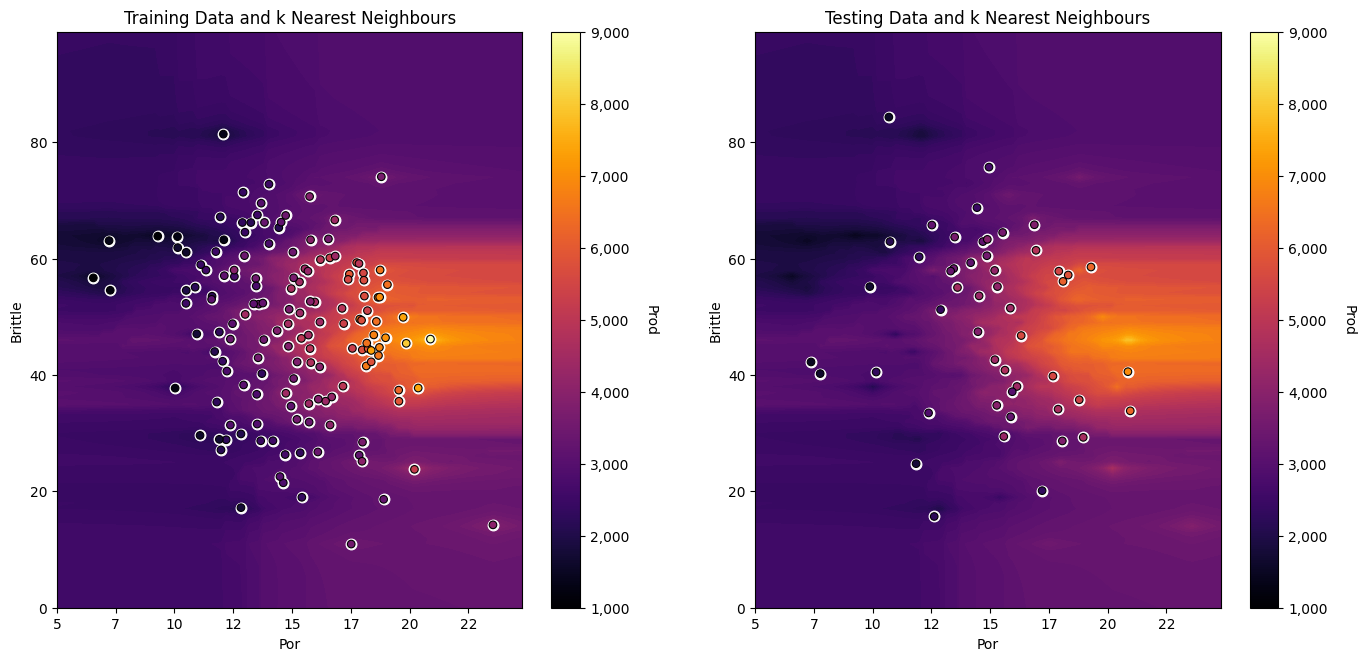

In [25]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.loc[:,sel_pred],df.loc[:,resp],test_size=0.25,random_state=73073)

neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=15, p = 1)
neigh_fit = neigh.fit(X_train_orig,y_train_orig)                # train the model with the training data

plt.subplot(121)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train_orig[sel_pred[0]],Xmin[0],Xmax[0],X_train_orig[sel_pred[1]],Xmin[1],Xmax[1],y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(122)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test_orig[sel_pred[0]],Xmin[0],Xmax[0],X_test_orig[sel_pred[1]],Xmin[1],Xmax[1],y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Do you see the horizontal banding?  The larger range of magnitudes of brittleness vs. porosity results in this banding.

* distances in the feature space are more sensitive to the relative changes in brittleness than porosity

Let's convert porosity to a fraction and observe the change in our predictor due to the arbitrary decision to work with porosity as a fraction vs. a percentage.

* by applying a $\frac{1}{100}$ factor to all the porosity values.

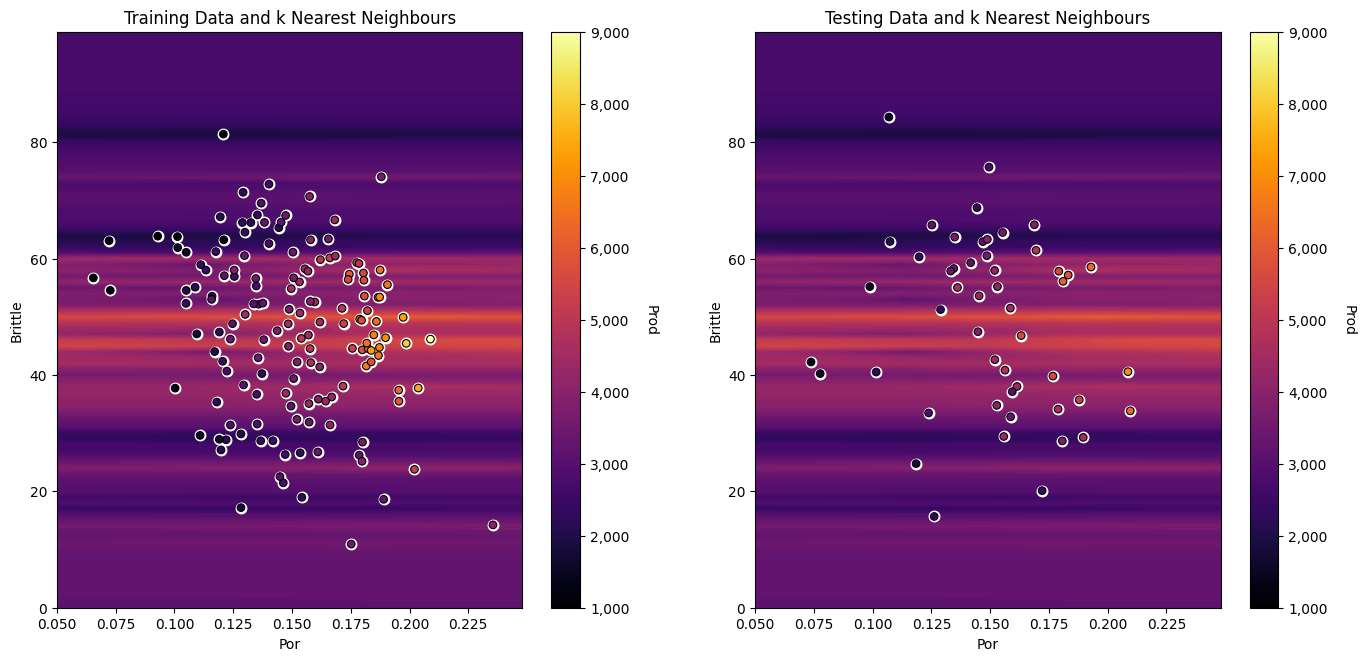

In [26]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df.loc[:,sel_pred],df.loc[:,resp],test_size=0.25,random_state=73073)

X_train_orig['Por'] = X_train_orig['Por']/100.0
X_test_orig['Por'] = X_test_orig['Por']/100.0

neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=15, p = 1)
neigh_fit = neigh.fit(X_train_orig,y_train_orig)                # train the model with the training data

plt.subplot(121)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train_orig[sel_pred[0]],Xmin[0]/100,Xmax[0]/100,X_train_orig[sel_pred[1]],Xmin[1],Xmax[1],y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours',False)
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(122)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test_orig[sel_pred[0]],Xmin[0]/100,Xmax[0]/100,X_test_orig[sel_pred[1]],Xmin[1],Xmax[1],y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours',False)
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

* this banding effect gets even more severe as we convert from percentage to fractional porosity, because distances in porosity appear so much closer than in brittleness, just because of the difference in feature ranges.

Our distance metric for assigning nearest neighbours is quite sensitive to the feature units.  We should always standardize all predictor features (put them on eequal footing) before we use them to build our $k$-nearest neighbour regression model!

#### k Nearest Neighbour Regression in scikit-learn with Pipelines

The need to standardize features, train, tune and retrain the tuned model with all the data may seem to be a lot of work!

* one solution is to use the Pipeline object from scikit-learn. 

Here's some highlights on Pipelines.

#####  Machine Learning Modeling Pipelines Basics

Machine learning workflows can be complicated, with various steps:

* data preparation, feature engineering transformations

* model parameter fitting

* model hyperparameter tuning

* modeling method selection

* searching over a large combinatorial of hyperparameters

* training and testing model runs

Pipelines are a scikit-learn class that allows for the encapsilation of a seuqence of data preparation and modeling steps

* then we can treat the pipeline as an object in our much condensed workflow

The pipeline class allows us to:

* improve code readability and to keep everything straight

* avoid common workflow problems like data leakage, testing data informing model parameter training 

* abstract common machine learning modeling and focus on building the best model possible

The fundamental philosophy is to treat machine learning as a combinatorial search to automate the determination of the best model (AutoML)

##### k-Nearest Neighbours with Pipelines

Here's compact, safe code for the entire model training and tuning process with scikit-learn pipelines

* the GridSearchCV object actually becomes the prediction model, with tuned hyperparameters retrained on all of the data!

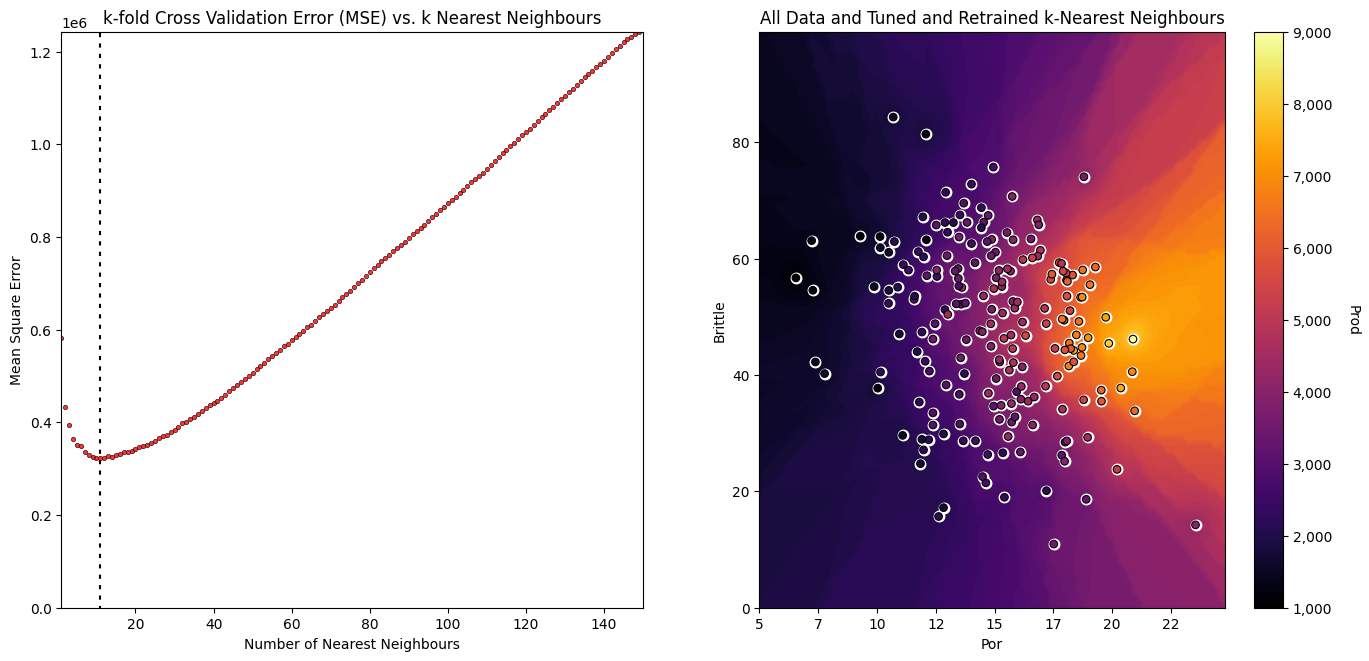

In [27]:
import os                                                     # to set current working directory 

folds = 4                                                   # number of k folds
k_min = 1; k_max = 150                                       # range of k hyperparameter to consider

X_pipe = df.loc[:,sel_pred]                                 # all the samples for the original features
y_pipe = df.loc[:,resp[0]]                             # warning this becomes a series, 1D ndarray with label

pipe = Pipeline([                                           # the machine learning workflow as a pipeline object
    ('scaler', StandardScaler()),
    ('knear', KNeighborsRegressor())
])

params = {                                                  # the machine learning workflow method's parameters
    'scaler': [StandardScaler()],
    'knear__n_neighbors': np.arange(k_min,k_max,1,dtype = int),
    'knear__metric': ['euclidean'],
    'knear__p': [2],
    'knear__weights': ['distance']
}

grid_cv_tuned = GridSearchCV(pipe, params, scoring = 'neg_mean_squared_error', # grid search cross validation 
                             cv=KFold(n_splits=folds,shuffle=False),
                             refit = True)
grid_cv_tuned.fit(X_pipe,y_pipe)                                      # fit model with tuned hyperparameters

plt.subplot(121)
visualize_tuned_model(grid_cv_tuned.best_params_['knear__n_neighbors'], # visualize the error vs. k 
                      grid_cv_tuned.cv_results_['param_knear__n_neighbors'],
                      abs(grid_cv_tuned.cv_results_['mean_test_score']))              

plt.subplot(122)                                            # visualize the tuned model
visualize_model(grid_cv_tuned,X[sel_pred[0]],Xmin[0],Xmax[0],X[sel_pred[1]],Xmin[1],Xmax[1],df[resp[0]],ymin,ymax,
                'All Data and Tuned and Retrained k-Nearest Neighbours')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

##### Check the Tuned Hyperparameters

In the GridSearchCV model object, there is a built in dictionary called best_params_ that includes all the tuned hyperparameters.

* note, over the range of k's the selected k, n_neighbors
* also, the other hyperparameters were specified, but we could have provided a range and scenarios for each to explore with the grid search method

When tuning more than 1 hyperparameter, the runtime will increase with the combinatorial of hyperparmaeters and the resulting model loss function, e.g., cv_results_['mean_test_score'], is sorted over all the hyperparameter cases

In [28]:
grid_cv_tuned.best_params_

{'knear__metric': 'euclidean',
 'knear__n_neighbors': 11,
 'knear__p': 2,
 'knear__weights': 'distance',
 'scaler': StandardScaler()}

It is also useful to look at the entire model object for more information. Including:

* the pipeline and all cases considered for the hyperparameter tuning.

In [29]:
grid_cv_tuned

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knear', KNeighborsRegressor())]),
             param_grid={'knear__metric': ['euclidean'],
                         'knear__n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,...
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149]),
                         'knear__p': [2], 'knear__weights': ['distance'],
                         'scaler': [StandardScaler()]},
             scoring='neg_mean_squared_error')

#### Comments

I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig) | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
